In [83]:
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
try:
    import open3d as o3d
except ImportError:
    import sys
    print(sys.exc_info())

from dosipy.utils.dataloader import load_ear_data
from dosipy.utils.integrate import elementwise_dblquad
from dosipy.utils.viz import (set_colorblind, save_fig, scatter_2d, scatter_3d,
                              fig_config)
from helpers import (clean_df, export_pcd, export_fields,
                     poynting_vector, get_imcolors)

In [52]:
def export_rect_idx(xyz, center, edge_length, view='xy'):
    """Extract specific points that correspond to a rectangle, defined
    with a central point and its edge length, from a point cloud.
    Parameters
    ----------
    xyz : numpy.ndarray
        Point cloud defining a model in 3-D.
    center : tuple or list
        z- and y-coordinate that defines the center of a desired
        rectangle.
    edge_length : float
        Edge length of a desired rectangle.
    view : string
        Point of view for point extraction. Currently supported `xy`
        and `zy`.
    Returns
    -------
    tuple
        Origin of a desired rectangle and indexes of all points from a point
        cloud that falls into a rectangle.
    """
    x_bound = [center[0] - edge_length / 2, center[0] + edge_length / 2]
    y_bound = [center[1] - edge_length / 2, center[1] + edge_length / 2]
    origin = [x_bound[0], y_bound[0]]
    if view == 'xy':
        col_idx = 0
    elif view == 'zy':
        col_idx = 2
    else:
        raise ValueError(f'Not supported view: {view}')
    idx_rect = np.where((xyz[:, col_idx] > x_bound[0])
                        & (xyz[:, col_idx] < x_bound[1])
                        & (xyz[:, 1] > y_bound[0])
                        & (xyz[:, 1] < y_bound[1]))[0]
    return origin, idx_rect

In [6]:
mode = 'te'
frequency = 26
df = load_ear_data(mode, frequency, surface='front')
df = clean_df(df)
xyz = export_pcd(df)

In [21]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
center = pcd.get_center()
xyz_t = np.c_[xyz[:, 0] - center[0],
              xyz[:, 1] - center[1],
              xyz[:, 2] - center[2]]
pcd_t = o3d.geometry.PointCloud()
pcd_t.points = o3d.utility.Vector3dVector(xyz_t)
center_t = pcd_t.get_center()
cframe = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=9, origin=center_t+np.array([6, -25, -20])
)
o3d.visualization.draw_geometries([pcd_t, cframe])

In [22]:
E, H = export_fields(df)
Sx, Sy, Sz = poynting_vector(E, H)

pcd_t.estimate_normals()
n = np.asarray(pcd_t.normals)

APD = abs(Sx.real * n[:, 0]
          + Sy.real * n[:, 1]
          + Sz.real * n[:, 2])

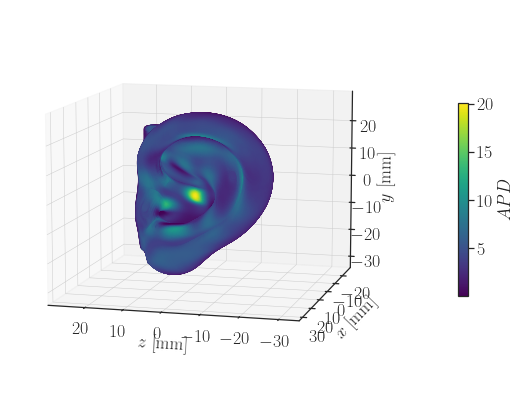

In [29]:
set_colorblind()
fig_config(latex=True, scaler=2, text_size=18)
label = '$APD$'
fig, ax = scatter_3d({'$z$ [mm]': xyz_t[:, 2],
                      '$x$ [mm]': xyz_t[:, 0],
                      '$y$ [mm]': xyz_t[:, 1],
                      label: APD},
                     elev=[10], azim=[105])

In [73]:
diameter = np.linalg.norm(
    pcd_t.get_max_bound() - pcd_t.get_min_bound()
)
radius = 10 ** 6
camera = [diameter, 0, 0]
_, mask = pcd_t.hidden_point_removal(camera, radius)
xyz_t_zy = xyz_t[mask]
APD_zy = APD[mask]
pcd_t_xy = o3d.geometry.PointCloud()
pcd_t_xy.points = o3d.utility.Vector3dVector(xyz_t_zy)

In [74]:
avg_center_idx = np.where(APD_zy == APD_zy.max())[0][0]

In [75]:
xyz_t_zy[avg_center_idx]

array([ 1.80424416, -2.14156894, -0.84484592])

In [78]:
avg_center = xyz_t_zy[avg_center_idx][1:]
edge_length = 10
area = edge_length ** 2
origin, idx_rect = export_rect_idx(xyz=xyz_t_zy,
                                   center=avg_center,
                                   edge_length=edge_length,
                                   view='zy')
xyz_rect = xyz_t_zy[idx_rect]
APD_rect = APD_zy[idx_rect]

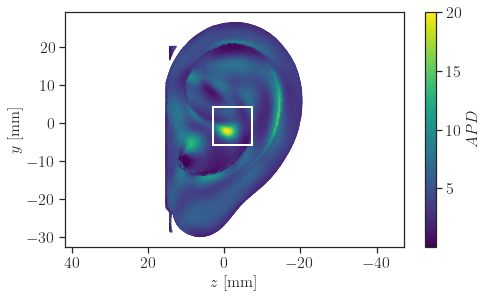

In [79]:
set_colorblind()
fig_config(latex=True, scaler=1.5, text_size=16)
fig, ax = scatter_2d({'$z$ [mm]': xyz_t_zy[:, 2],
                      '$y$ [mm]': xyz_t_zy[:, 1],
                      label: APD_zy}, s=0.1)
patch_rect = Rectangle(origin, edge_length, edge_length, fc='None', lw=2)
ax.add_patch(patch_rect)
ax.invert_xaxis()

In [86]:
APD_av = elementwise_dblquad(points=np.c_[xyz_rect[:, 2], xyz_rect[:, 1]],
                             values=APD_rect,
                             degree=11) / area
APD_av

/home/alk/anaconda3/envs/dosipy/lib/python3.9/site-packages/scipy/interpolate/rbf.py:266: LinAlgWarning: Ill-conditioned matrix (rcond=6.44626e-17): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


6.020492879465682